# 4. Qiskit での実装

In [1]:
"""
色々準備
"""
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit.circuit import Gate

# import basic plot tools
from qiskit.visualization import plot_histogram

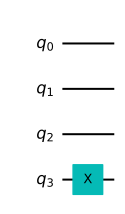

In [2]:
"""ドイチュ・ジョサのQiskitでの実装
定置型オラクルを作る
定値型は、入力は出力に影響を与えないため、出力量子ビットは0または1にランダムに設定します。
"""
# オラクルの入力レジスタ
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

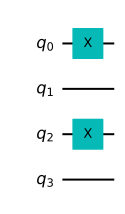

In [3]:
"""
次に、分布型オラクルを作る
"""
balanced_oracle = QuantumCircuit(n+1)

b_str = "101"  # Xゲートを配置するキーに利用する(1の場合はXゲートを置き、0の場合は何もしない)

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

balanced_oracle.draw()

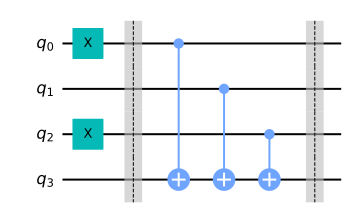

In [4]:
"""
次に、各入力量子ビットを制御ビットとし、出力量子ビットをターゲットビットとして、制御NOTゲートを実装します。
"""
# Use barrier as divider
balanced_oracle.barrier()

# CNOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

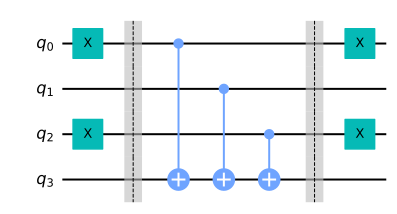

In [5]:
"""
最後に、2つのセルからコードを繰り返して、制御ビットをXゲートでラップします。
"""
# Place X-gates again.
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

balanced_oracle.draw()

# 4.3 アルゴリズムの完成

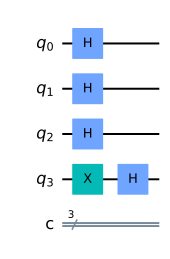

In [6]:
"""
それでは、すべてをまとめましょう。 
アルゴリズムの最初のステップは、入力量子ビットを状態 |+⟩  に、出力量子ビットを状態 |−⟩ に初期化することです。
"""
dj_circuit = QuantumCircuit(n+1, n)

for qubit in range(n):
    dj_circuit.h(qubit)

# put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

dj_circuit.draw()

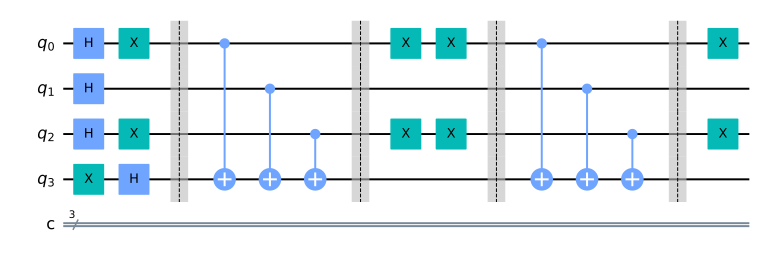

In [8]:
"""
次に、オラクルを適用しましょう。ここでは、上記で作成したbalanced_oracle を適用します。
"""
# add oracle
dj_circuit += balanced_oracle

dj_circuit.draw()

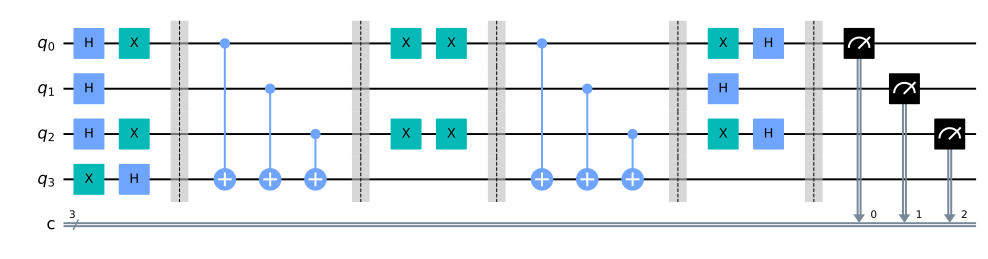

In [9]:
"""
最後に、  n 個の入力量子ビットにHゲートを適用し、入力レジスターを測定します。
"""
# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

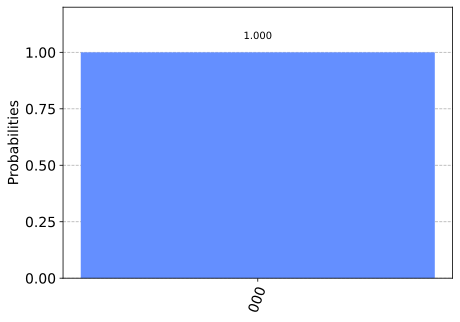

In [10]:
"""
出力を観てみる

以下の結果から、000を測定する可能性は0％であることがわかります(100%の確率で000なら定置型である)。これにより、関数が分布型であることが正しく予測されます。
"""
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

# 4.4 一般化された回路

In [11]:
"""
次のコードは、一般化されたドイチ-ジョサのオラクルを作成し、量子ゲートに変換する関数です。
caseで分布型か定値型かを区別し（'balanced'または constant）、また nは入力レジスターのサイズです
"""
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the CNOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    elif case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate


In [12]:
"""
このオラクルのゲートを入力して、ドイチ-ジョサのアルゴリズムを実行する関数も作成しましょう。
"""
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

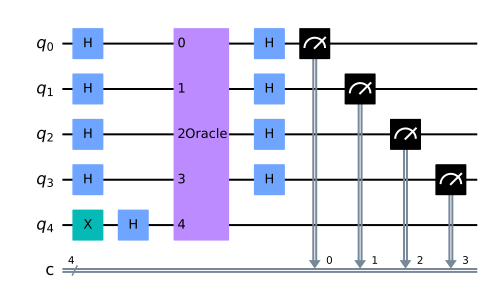

In [13]:
"""
最後に、これらの関数を使用してアルゴリズムを試してみましょう。
"""
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

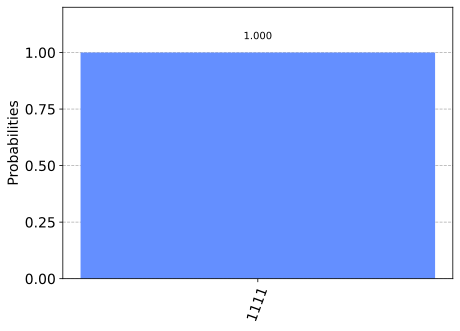

In [14]:
"""
この回路を実行した結果を見てみます。
"""
results = execute(dj_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

# 5. 実デバイスでの実験

In [15]:
"""
実デバイス(IBMQ)での回路の実行は、以下のようにして行います。まず、この回路が実行可能で最も空いているデバイスを探します。
"""
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [16]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(dj_circuit, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)

Job Status: job has successfully run


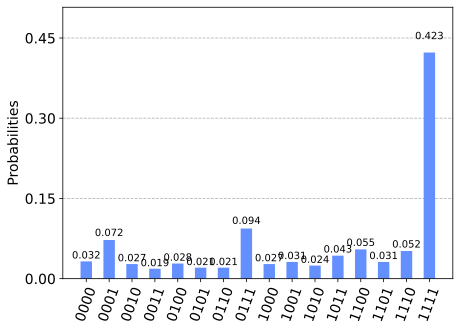

In [17]:
"""
ご覧のとおり、最も可能性の高い結果は1111です。他の結果は、量子計算の誤差によるものです
"""
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

# 6. 演習問題

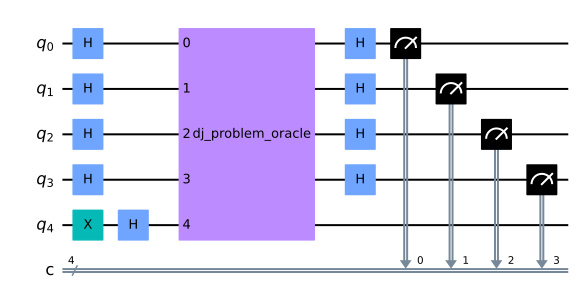

In [18]:
"""
(1) 異なる形の分布型、定値型のオラクルを作成できますか？

関数dj_problem_oracleは、n = 4のドイチ-ジョサオラクルをゲートの形式で返します。ゲートの入力は5量子ビットで、最後の量子ビット（q_4）が出力量子ビットです（上記のオラクルの例のように）。 dj_problem_oracle に1〜5の異なる整数を指定することで、異なるオラクルを取得できます。ドイチ-ジョサのアルゴリズムを使用して、各オラクルが分布型か定値型かを判断してください（注：実デバイスではなく、qasm_simulatorを使用して試すことを強くお勧めします） 。
"""
from qiskit_textbook.problems import dj_problem_oracle

n = 4
oracle = dj_problem_oracle(3)
oracle.name = "dj_problem_oracle"

qc = dj_algorithm(oracle, n)

qc.draw()

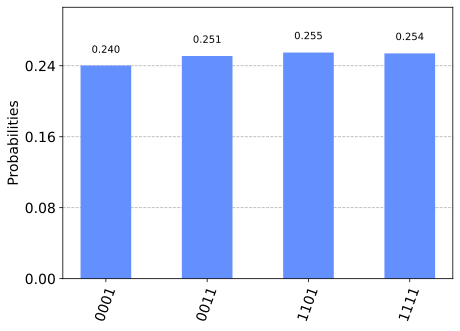

In [19]:
"""
この回路を実行した結果を見てみます。
"""
results = execute(qc, backend=BasicAer.get_backend("qasm_simulator"), shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)